<a href="https://colab.research.google.com/github/MeetGhasadiya/waste_classification/blob/main/waste1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import random
import shutil


In [5]:
!pip install kagglehub


In [6]:
import kagglehub

# Download dataset
DATASET_PATH = kagglehub.dataset_download("sumn2u/garbage-classification-v2")
print("Dataset downloaded at:", DATASET_PATH)


Using Colab cache for faster access to the 'garbage-classification-v2' dataset.
Dataset downloaded at: /kaggle/input/garbage-classification-v2


In [7]:
# This folder contains class-wise images
SOURCE_DIR = os.path.join(DATASET_PATH, "standardized_256")

print("Classes found:", os.listdir(SOURCE_DIR))


Classes found: ['metal', 'glass', 'biological', 'paper', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic']


In [8]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [9]:
BASE_DIR = "/content/drive/MyDrive/waste_dataset_split"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(d, exist_ok=True)

print("Split folders created at:", BASE_DIR)


Split folders created at: /content/drive/MyDrive/waste_dataset_split


In [10]:
train_ratio = 0.7
val_ratio   = 0.15
test_ratio  = 0.15

random.seed(42)  # reproducibility (paper ke liye IMPORTANT)

classes = os.listdir(SOURCE_DIR)

for cls in classes:
    cls_path = os.path.join(SOURCE_DIR, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)

    total = len(images)
    train_end = int(train_ratio * total)
    val_end   = int((train_ratio + val_ratio) * total)

    train_imgs = images[:train_end]
    val_imgs   = images[train_end:val_end]
    test_imgs  = images[val_end:]

    for split_dir, split_imgs in zip(
        [TRAIN_DIR, VAL_DIR, TEST_DIR],
        [train_imgs, val_imgs, test_imgs]
    ):
        cls_split_dir = os.path.join(split_dir, cls)
        os.makedirs(cls_split_dir, exist_ok=True)

        for img in split_imgs:
            src = os.path.join(cls_path, img)
            dst = os.path.join(cls_split_dir, img)
            if not os.path.exists(dst):
                shutil.copy(src, dst)


In [11]:
import os

print("Train folders:", sorted(os.listdir("/content/drive/MyDrive/waste_dataset_split/train")))
print("Val folders:", sorted(os.listdir("/content/drive/MyDrive/waste_dataset_split/val")))
print("Test folders:", sorted(os.listdir("/content/drive/MyDrive/waste_dataset_split/test")))



Train folders: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Val folders: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Test folders: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [12]:
def count_images(directory):
    total = 0
    for cls in os.listdir(directory):
        total += len(os.listdir(os.path.join(directory, cls)))
    return total

print("Train images:", count_images(TRAIN_DIR))
print("Validation images:", count_images(VAL_DIR))
print("Test images:", count_images(TEST_DIR))


Train images: 9339
Validation images: 2003
Test images: 2006


In [13]:
import os

BASE_DIR = "/content/drive/MyDrive/waste_dataset_split"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

MODEL_DIR = "/content/drive/MyDrive/waste_models"
os.makedirs(MODEL_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(MODEL_DIR, "best_model.keras")


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 9339 images belonging to 10 classes.
Found 2003 images belonging to 10 classes.


In [15]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)

checkpoint_cb = ModelCheckpoint(
    BEST_MODEL_PATH,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]


In [16]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [17]:
IMG_SIZE = 224
NUM_CLASSES = train_gen.num_classes  # auto from generator

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# 🔒 Freeze backbone
base_model.trainable = False

# Classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
EPOCHS_PHASE1 = 6

history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2001 - loss: 2.4389
Epoch 1: val_accuracy improved from -inf to 0.63155, saving model to /content/drive/MyDrive/waste_models/best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 675s 2s/step - accuracy: 0.2005 - loss: 2.4375 - val_accuracy: 0.6316 - val_loss: 1.2285 - learning_rate: 1.0000e-04
Epoch 2/6
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5898 - loss: 1.2961
Epoch 2: val_accuracy improved from 0.63155 to 0.74638, saving model to /content/drive/MyDrive/waste_models/best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 692s 2s/step - accuracy: 0.5899 - loss: 1.2957 - val_accuracy: 0.7464 - val_loss: 0.8291 - learning_rate: 1.0000e-04
Epoch 3/6
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7097 - loss: 0.9406
Epoch 3: val_accuracy improved from 0.74638 to 0.79031, saving model to /content/drive/MyDrive/waste_models/best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 654s 2s/step - accuracy: 0.7097 - loss: 0.9404 - val_ac

In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [3]:
import os

MODEL_DIR = "/content/drive/MyDrive/waste_models"
BEST_MODEL_PATH = os.path.join(MODEL_DIR, "best_model.keras")

print("Model exists:", os.path.exists(BEST_MODEL_PATH))


Model exists: True


In [4]:
from tensorflow.keras.models import load_model

model = load_model(BEST_MODEL_PATH)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,296,416 (8.76 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 25,622 (100.09 KB)

In [7]:
for layer in model.layers:
    layer.trainable = False


In [9]:
import tensorflow as tf


FINE_TUNE_AT = 30  # last 30 layers

for layer in model.layers[-FINE_TUNE_AT:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True


In [10]:
trainable_count = sum(layer.trainable for layer in model.layers)
print("Trainable layers:", trainable_count)


Trainable layers: 21


In [12]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [13]:
BASE_DIR = "/content/drive/MyDrive/waste_dataset_split"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")



In [14]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 9339 images belonging to 10 classes.
Found 2003 images belonging to 10 classes.


In [16]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)
import os


In [17]:
MODEL_DIR = "/content/drive/MyDrive/waste_models"
os.makedirs(MODEL_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(MODEL_DIR, "best_model.keras")


In [18]:
checkpoint_cb = ModelCheckpoint(
    BEST_MODEL_PATH,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]


In [19]:
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=6,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8062 - loss: 0.5832
Epoch 1: val_accuracy improved from -inf to 0.87069, saving model to /content/drive/MyDrive/waste_models/best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 3106s 11s/step - accuracy: 0.8062 - loss: 0.5831 - val_accuracy: 0.8707 - val_loss: 0.4151 - learning_rate: 1.0000e-05
Epoch 2/6
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8345 - loss: 0.4930
Epoch 2: val_accuracy improved from 0.87069 to 0.88467, saving model to /content/drive/MyDrive/waste_models/best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 802s 3s/step - accuracy: 0.8346 - loss: 0.4930 - val_accuracy: 0.8847 - val_loss: 0.3639 - learning_rate: 1.0000e-05
Epoch 3/6
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8518 - loss: 0.4356
Epoch 3: val_accuracy improved from 0.88467 to 0.89066, saving model to /content/drive/MyDrive/waste_models/best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 759s 3s/step - accuracy: 0.8518 - loss: 0.4356 - val_

In [20]:
from tensorflow.keras.models import load_model
import os

MODEL_DIR = "/content/drive/MyDrive/waste_models"
BEST_MODEL_PATH = os.path.join(MODEL_DIR, "best_model.keras")

model = load_model(BEST_MODEL_PATH)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 5,010,656 (19.11 MB)

 Trainable params: 1,369,930 (5.23 MB)

 Non-trainable params: 900,864 (3.44 MB)

 Optimizer params: 2,739,862 (10.45 MB)

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BASE_DIR = "/content/drive/MyDrive/waste_dataset_split"
TEST_DIR = os.path.join(BASE_DIR, "test")

IMG_SIZE = 224
BATCH_SIZE = 32

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False   # VERY IMPORTANT
)


Found 2006 images belonging to 10 classes.


In [22]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 587s 9s/step - accuracy: 0.8941 - loss: 0.2985
Test Accuracy: 88.14%
Test Loss: 0.3425


In [23]:
import numpy as np

y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())


63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step


In [24]:
from sklearn.metrics import classification_report

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names
)
print(report)


              precision    recall  f1-score   support

     battery       0.95      0.90      0.93       123
  biological       0.97      0.92      0.95       122
   cardboard       0.92      0.83      0.87       230
     clothes       0.97      0.99      0.98       298
       glass       0.84      0.88      0.86       300
       metal       0.82      0.80      0.81       149
       paper       0.77      0.88      0.82       207
     plastic       0.81      0.75      0.78       257
       shoes       0.94      0.98      0.96       245
       trash       0.85      0.77      0.81        75

    accuracy                           0.88      2006
   macro avg       0.88      0.87      0.88      2006
weighted avg       0.88      0.88      0.88      2006



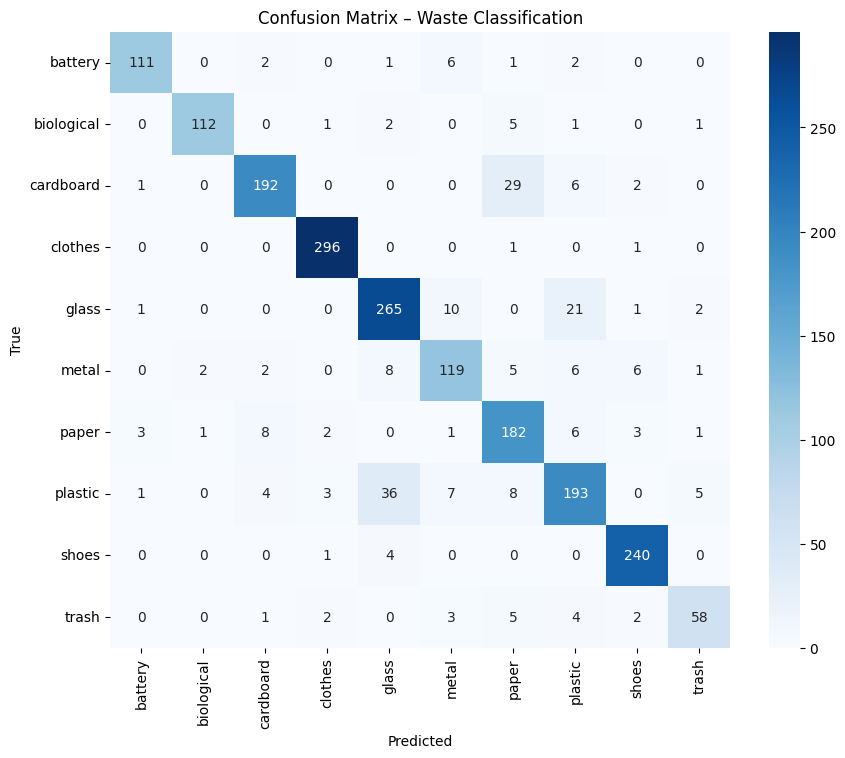

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Waste Classification")
plt.show()
